Version 1: Works for circuit with N qubits that does not have any constrains
<br>
Version 2: Constrains on not being able to do 2-qubits gates over the qubits that are not directly connected in the picture, 
<br>
**constant 6 qubit circuit**
<br>
Version 3:  Constrains on not being able to do 2-qubits gates over the qubits that are not directly connected in the picture, 
<br>
**allowed qubit ranges**
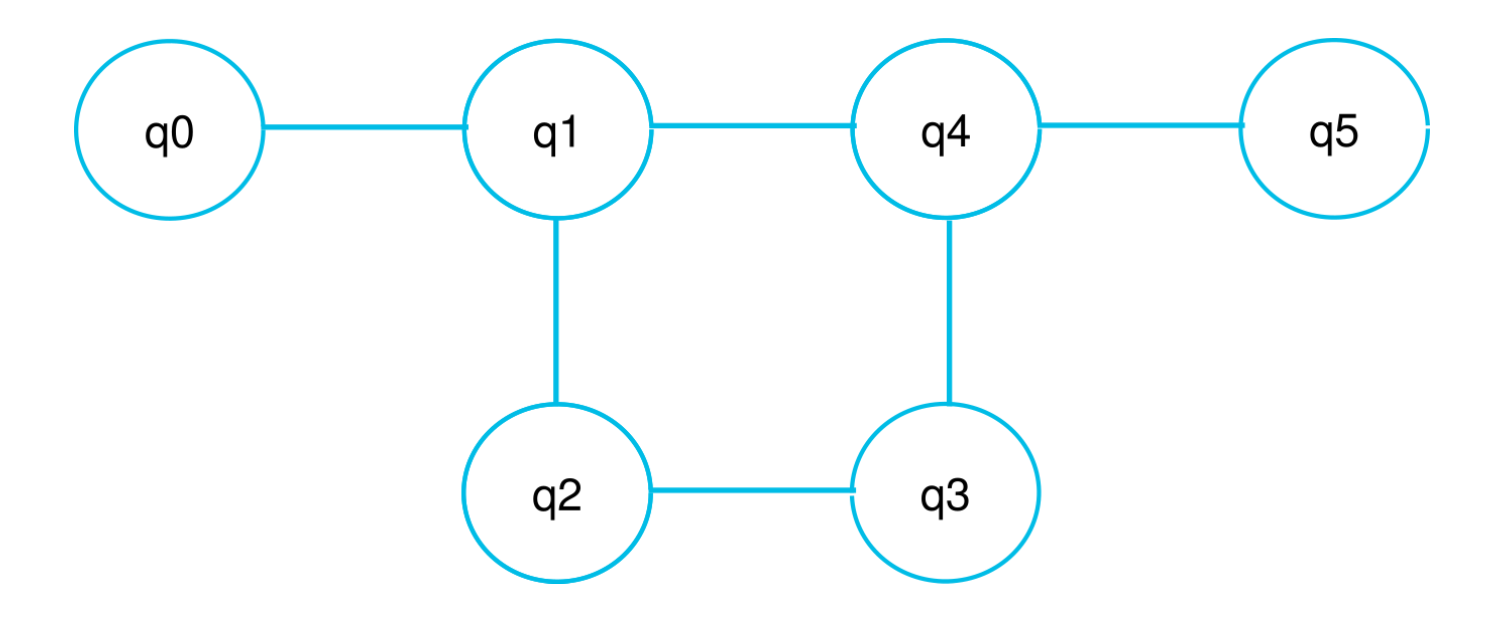

In [282]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

In [283]:
from inspect import signature
import random
from math import pi

In [284]:
def random_circuit_v1(num_qubits, depth, basis_gates):
    qc = QuantumCircuit(num_qubits)
    def apply_random_gate_to_circuit(circuit, n):
        str_gate = random.sample(basis_gates, 1)[0]
        a = getattr(circuit, str_gate)
        lst = []
        swap_range = [i for i in range(n)]
        for x, y in signature(a).parameters.items():
            if (x != 'label' and x != 'ctrl_state'):
                if x.find('qubit') != -1:
                    idx = random.sample(swap_range, 1)[0]
                    lst.append(idx)
                    swap_range.remove(idx)
                else:
                    lst.append(random.uniform(-pi, pi))
        a(*lst)
        # END
    
    while (qc.depth() < depth):
        apply_random_gate_to_circuit(qc, num_qubits)
    
    return qc

Depth of this circuit is :  5


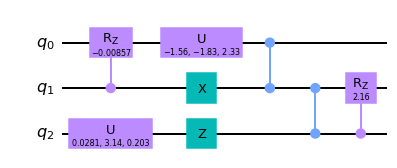

In [285]:
############# example usage: version 1:
basis_gates = ['cx', 'u', 'rx', 'crx', 'h', 'x', 'z', 'cz', 'crz', 'cu']
qc = random_circuit_v1(num_qubits = 3, depth = 5, basis_gates = basis_gates)
print("Depth of this circuit is : ", qc.depth())
qc.draw('mpl')


In [286]:
### the only real difference I use is that the control gates are not allowed 
### over the connections that don't directly exists
### so as there are exactly direct 6 connections
### and therefore if we randomly choose a control gate (or any ? 2-qubit gate)
### it must choose to fit itself into these 6 positions
### I am going to remove the num_qubits and force them to be 6 in this version
def random_circuit_v2_6qubits_grid6(depth, basis_gates):
    num_qubits = 6 # constant!
    qc = QuantumCircuit(num_qubits)
    def get_swap_range(a):
        qubits = 0
        for x in signature(a).parameters:
            if (x.find('qubit') != -1):
                qubits += 1
        if qubits == 2:
            edges = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [1, 4]]
            edge_range = [i for i in range(len(edges))]
            return edges[random.sample(edge_range, 1)[0]]
        return [i for i in range(num_qubits)]
    def apply_random_gate_to_circuit(circuit, n):
        str_gate = random.sample(basis_gates, 1)[0]
        a = getattr(circuit, str_gate)
        lst = []
        swap_range = get_swap_range(a)
        for x, y in signature(a).parameters.items():
            if (x != 'label' and x != 'ctrl_state'):
                if x.find('qubit') != -1: ## if qubit index then we use integers
                    idx = random.sample(swap_range, 1)[0]
                    lst.append(idx)
                    swap_range.remove(idx)
                else: ## otherwise it's an angle ? 
                    lst.append(random.uniform(-pi, pi))
        a(*lst)
        # END
    
    while (qc.depth() < depth):
        apply_random_gate_to_circuit(qc, num_qubits)
    
    return qc

Depth of this circuit is :  14


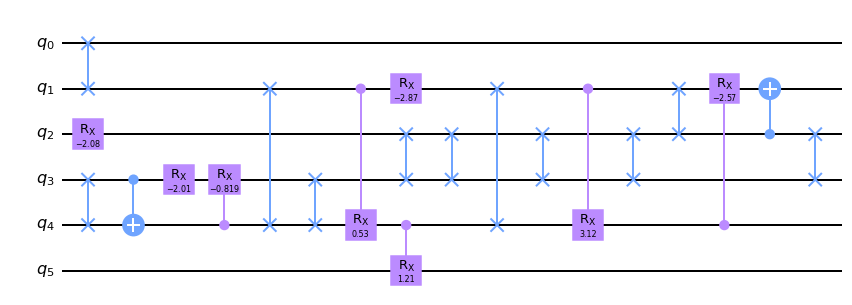

In [287]:
############# example usage: version 2:
basis_gates = ['cx', 'swap', 'crx', 'rx']
depth = 14
qc = random_circuit_v2_6qubits_grid6(depth = depth, basis_gates = basis_gates)
print("Depth of this circuit is : ", qc.depth())
qc.draw('mpl')

In [290]:
### the 6 qubit constant is a harsh constraint
### I am going to loosen it by allowing the user to provide a range of qubits 
### they would like to work on 
### the contraint here is that the range must be in order increasing by 1
### example: [0,1,2,3,4,5] or eg: [2,3,4] and not: [0,3,5]
### but this way we can select to work with any number of qubits (up to 6)
### this modifies the allowed 2-qubit gates indexing slightly

### added bunch of checks for stability
def random_circuit_v3_qubit_range_grid6(qubit_range, depth, basis_gates):
    num_qubits = len(qubit_range) 
    qc = QuantumCircuit(num_qubits)
    if (num_qubits > 6):
        print('Not a valid circuit range, we only have 6 qubits')
        return qc
    for qubit in qubit_range: # check range
        if (qubit < 1 or qubit > 6): # wrong qubit indexing
            print("Not a valid range!")
            return qc
    for idx in range(1, len(qubit_range)): # check range
        if (qubit_range[idx] != qubit_range[idx - 1] + 1): ## wrong sequence
            print("Not a valid range!")
            return qc
    def count_qubits(a):
        qubits = 0
        for x in signature(a).parameters:
            if (x.find('qubit') != -1):
                qubits += 1
        return qubits
    
    for str_gate in basis_gates: # check gates
        a = getattr(circuit, str_gate)
        cnt = count_qubits(a)
        if (cnt > num_qubits):
            basis_gates.remove(str_gate)
            # this gate can't be used anyway
    if (basis_gates == []):
        print("No valid gates were given for the range provided!")
        return qc
    
    def get_swap_range(a):
        if num_qubits == 1:
            return [0]
        qubits = count_qubits(a)
        if qubits == 2:
            edges = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [1, 4]]
            for idx in range(len(edges) - 1, -1, -1): # remove edges we can't use
                edge = edges[idx]
                if (edge[0] not in qubit_range) or (edge[1] not in qubit_range):
                    edges.remove(edge)
            for edge in edges: # shift edges to 0
                for i in range(2):
                    edge[i] -= qubit_range[0]
            edge_range = [i for i in range(len(edges))]
#             print(edge_range)
#             print(edges)
            return edges[random.sample(edge_range, 1)[0]]
        return [i for i in range(num_qubits)]
    def apply_random_gate_to_circuit(circuit, n):
        str_gate = random.sample(basis_gates, 1)[0]
        a = getattr(circuit, str_gate)
        lst = []
        swap_range = get_swap_range(a)
#         print(swap_range)
        for x, y in signature(a).parameters.items():
            if (x != 'label' and x != 'ctrl_state'):
                if x.find('qubit') != -1: ## if qubit index then we use integers
                    idx = random.sample(swap_range, 1)[0]
                    lst.append(idx)
                    swap_range.remove(idx)
                else: ## otherwise it's an angle ? 
                    lst.append(random.uniform(-pi, pi))
        a(*lst)
        # END
    
    while (qc.depth() < depth):
        apply_random_gate_to_circuit(qc, num_qubits)
    
    return qc

Depth of this circuit is :  10


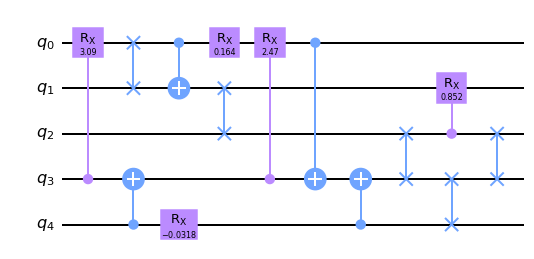

In [291]:
############# example usage: version 3:
basis_gates = ['cx', 'swap', 'crx', 'rx']
depth = 10
qubit_range = [1,2,3,4,5] #for example: skipping qubit 0 
qc = random_circuit_v3_qubit_range_grid6(qubit_range = qubit_range, depth = depth, basis_gates = basis_gates)
print("Depth of this circuit is : ", qc.depth())
qc.draw('mpl')